<a href="https://colab.research.google.com/github/yufeili1/zhsf1/blob/main/600760_sma_and_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Execute this block to start importing the libraries and helper functions

import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#!pip install pyfolio 
!pip install git+https://github.com/quantopian/pyfolio
import pyfolio as pf

# Interative charting
import altair as alt
alt.data_transformers.disable_max_rows()

# Enable Google interactive table
from google.colab import data_table
data_table.enable_dataframe_formatter()

SCREEN_X, SCREEN_Y = 12, 8

!wget https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/plot.py
import plot

def test_ma(df, lead, lag, pc_thresh = 0.025):
    ma_df = df.copy()

    # build the lead/lag indicator
    ma_df['lead'] = ma_df['close'].rolling(lead).mean()
    ma_df['lag'] = ma_df['close'].rolling(lag).mean()

    # Remove the NaN rows
    ma_df.dropna(inplace = True)

    # calculate the lead and lag difference
    ma_df['lead-lag'] = ma_df['lead'] - ma_df['lag']
    ma_df['pc_diff'] = ma_df['lead-lag'] / ma_df['close']

    # signal column will govern the buying and selling logic as described above; 
    # 1 means that we are long, -1 means that we are short and 0 means no position
    ma_df['signal'] = np.where(ma_df['pc_diff'] > pc_thresh, 1, 0)
    ma_df['signal'] = np.where(ma_df['pc_diff'] < -pc_thresh, -1, ma_df['signal'])
    
    # Market column as log returns of price series - which is the simple buy-and-hold performance
    ma_df['Buy-Hold'] = np.log(ma_df['close'] / ma_df['close'].shift(1))
    
    # compute our Strategy returns by multiplying signal (shifted forward to match the Market column
    ma_df['Strategy'] = ma_df['signal'].shift(1) * ma_df['Buy-Hold']
    
    # perform a cumulative sum operation as well as apply an exponent on Market and Strategy log returns 
    # in order to recover the original normalised series
    ma_df[['Buy-Hold','Strategy']] = ma_df[['Buy-Hold','Strategy']].cumsum().apply(np.exp)
    return ma_df

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-ut4k8fd7
  Running command git clone --filter=blob:none --quiet https://github.com/quantopian/pyfolio /tmp/pip-req-build-ut4k8fd7
  Resolved https://github.com/quantopian/pyfolio to commit 4b901f6d73aa02ceb6d04b7d83502e5c6f2e81aa
  Preparing metadata (setup.py) ... done
--2023-05-25 04:29:47--  https://raw.githubusercontent.com/kenwkliu/ideas/master/colab/plot.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824 [text/plain]
Saving to: ‘plot.py.2’

plot.py.2           100%[===================>]     824  --.-KB/s    in 0s      

2023-05-25 04:29:47 (47.0 MB/s) - ‘plot.py.2’ saved [824/824]



#1 Download historical 600760 daily data

In [ ]:
url = 'https://raw.githubusercontent.com/Wenleiguo/zhsf/main/K-700760.csv'
df = pd.read_csv(url)

df['date'] = pd.to_datetime(df['date'])
df.set_index('date',inplace=True)

# Filter the start date
#df = df.loc['2020-01-02':]

df

,code,open,high,low,close,quote volume,volume
date,,,,,,,
2020-01-02,600760,22.4241,22.7126,22.1919,22.3748,"8,138,775","259,471,132"
2020-01-03,600760,22.4311,23.1770,22.2623,23.0503,"16,751,728","543,653,168"
2020-01-06,600760,23.5217,24.0635,23.1981,23.3247,"17,125,229","572,508,496"
2020-01-07,600760,23.2332,23.6062,22.9377,23.3388,"8,738,074","290,171,120"
2020-01-08,600760,23.9369,24.0424,23.1699,23.5851,"15,494,704","521,662,368"
...,...,...,...,...,...,...,...
2023-05-18,600760,60.7100,60.7200,59.7500,59.8400,"8,494,652","510,342,688"
2023-05-19,600760,59.5900,60.6700,59.2400,59.6100,"8,677,333","519,726,656"
2023-05-22,600760,59.6100,60.2400,58.8000,59.4300,"6,939,840","412,604,544"


In [ ]:
df.to_csv('600760.csv')

#2: Visualize and understand the data (Exploratory Data Analysis)
Plot OHLCV (Open/High/Low/Close/Volume) candle sticks

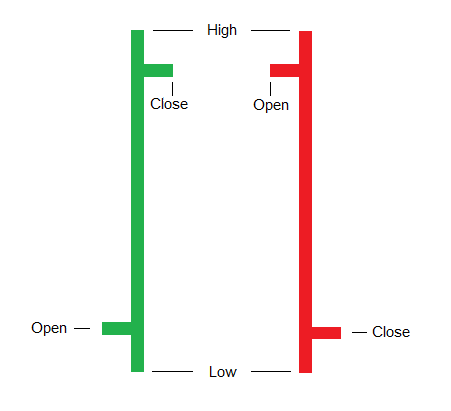

In [ ]:
plot.ohlcv(df, 'date', 'open', 'high', 'low', 'close', 'volume')

count    820.000000
mean       0.001638
std        0.031007
min       -0.100054
25%       -0.015068
50%        0.001036
75%        0.014888
max        0.100080
Name: close, dtype: float64


<Axes: >

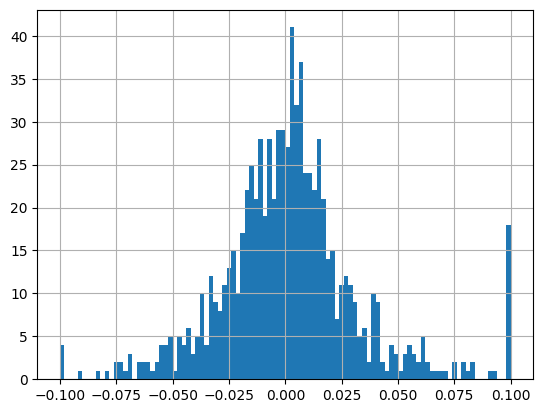

In [ ]:
print(df['close'].pct_change().describe())
df['close'].pct_change().hist(bins=100)

In [ ]:
lead = 45 # short-term moving average days
lag = 125 # long-term moving average days

df['lead'] = df['close'].rolling(lead).mean()
df['lag'] = df['close'].rolling(lag).mean()

COLUMNS = ['close', 'lead', 'lag']
df[COLUMNS]

,close,lead,lag
date,,,
2020-01-02,22.3748,NaN,NaN
2020-01-03,23.0503,NaN,NaN
2020-01-06,23.3247,NaN,NaN
2020-01-07,23.3388,NaN,NaN
2020-01-08,23.5851,NaN,NaN
...,...,...,...
2023-05-18,59.8400,55.952000,58.57064
2023-05-19,59.6100,56.013111,58.51704
2023-05-22,59.4300,56.098889,58.46656


In [ ]:
plot_data = df[COLUMNS].reset_index().melt('date')

alt.Chart(plot_data).mark_line().encode(
  x='date:T',
  y='value',
  color='variable'
).properties(
  width=800,
  height=600
).interactive()

alt.Chart(...)

#3: Back testing the strategy with the historical data
 
Strategy Signal: (1, -1, 0)

*   **1 LONG**: if Leading SMA is above Lagging SMA by the threshold -> hold 1 long position of bitcoin
*   **-1 SHORT**: if Leading SMA is below Lagging SMA by the threshold -> short 1 bitcoin
*   **0 FLAT**: if the difference of Leading and Lagging SMA is less than the threshold -> flatten the bitcoin position


Back testing parameters
*   **lead**: short-term moving average days
*   **lag**: long-term moving average days
*   **threshold**: sensitivity of the strategy and is used to filter out weak signals. **Smaller the number means more sensitive** to the signals (which usually means more long/short positions)

In [ ]:
#@title Run back testing with different parameters 

lead = 45 #@param {type:"integer"}
lag = 125 #@param {type:"integer"}
threshold = 0.1 #@param {type:"slider", min:0, max:0.5, step:0.01}

ma_df = test_ma(df, lead, lag, threshold).dropna()

SMA_COLUMNS = ['close', 'lead', 'lag', 'lead-lag', 'pc_diff', 'signal', 'Buy-Hold', 'Strategy']
ma_df[SMA_COLUMNS]

,close,lead,lag,lead-lag,pc_diff,signal,Buy-Hold,Strategy
date,,,,,,,,
2020-07-13,41.3515,25.050093,22.438434,2.611659,0.063158,0,1.031382,1.000000
2020-07-14,41.7332,25.440409,22.587898,2.852511,0.068351,0,1.040902,1.000000
2020-07-15,40.4962,25.794636,22.725270,3.069366,0.075794,0,1.010049,1.000000
2020-07-16,38.2130,26.100469,22.844263,3.256206,0.085212,0,0.953102,1.000000
2020-07-17,42.0371,26.487529,22.991879,3.495650,0.083156,0,1.048482,1.000000
...,...,...,...,...,...,...,...,...
2023-05-18,59.8400,55.952000,58.570640,-2.618640,-0.043761,0,1.492519,0.641982
2023-05-19,59.6100,56.013111,58.517040,-2.503929,-0.042005,0,1.486782,0.641982
2023-05-22,59.4300,56.098889,58.466560,-2.367671,-0.039840,0,1.482293,0.641982


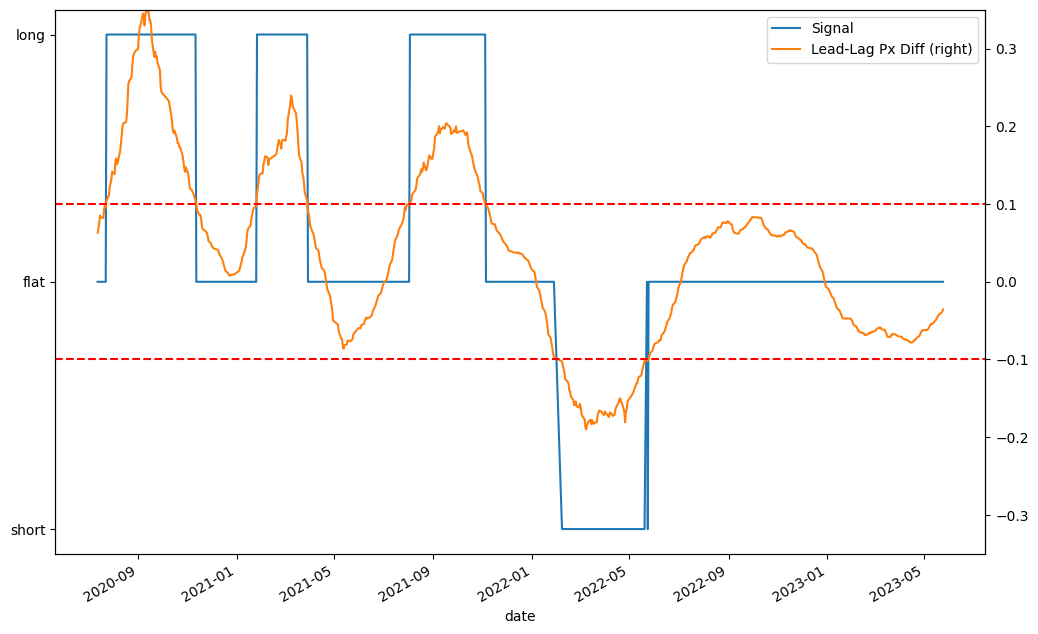

In [ ]:
# Plot signal over "lead-lag" price difference (align at 0)
# Plot signal as the left y-axis
ax1 = ma_df.signal.plot(label='Signal', legend=True, figsize=(SCREEN_X, SCREEN_Y))
ax1.set_ylim(-1.1, 1.1)
plt.yticks([-1, 0, 1], ['short', 'flat', 'long'])

# Plot "lead-lag" price difference as the right y-axis
ax2 = ma_df.pc_diff.plot(secondary_y=True, label='Lead-Lag Px Diff', legend=True, figsize=(SCREEN_X, SCREEN_Y))
SAFE_MARGIN = 0.05
ylimit = max(round(ma_df.pc_diff.max(), 1), - round(ma_df.pc_diff.min(), 1)) + SAFE_MARGIN
ax2.set_ylim(-ylimit, ylimit)

plt.axhline(y=threshold, color='r', linestyle='--')
plt.axhline(y=-threshold, color='r', linestyle='--')

In [ ]:
ma_df[['Buy-Hold', 'Strategy']].iloc[-1]

Buy-Hold    1.446626
Strategy    0.641982
Name: 2023-05-24 00:00:00, dtype: float64

<Axes: xlabel='date'>

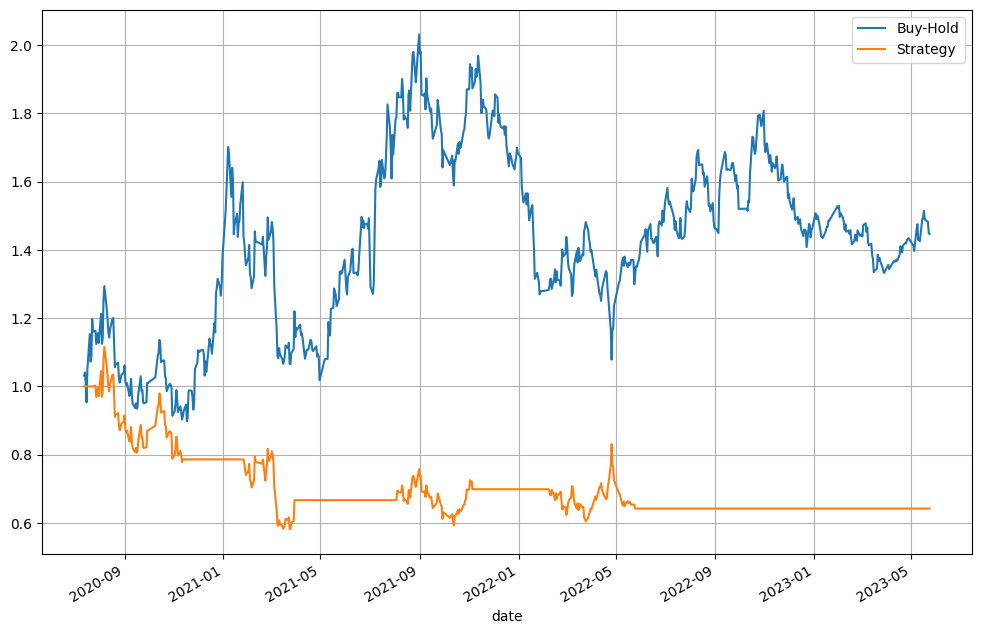

In [ ]:
ma_df[['Buy-Hold', 'Strategy']].plot(figsize = (SCREEN_X, SCREEN_Y), grid=True)

In [ ]:
leads = np.arange(5, 100, 5) 
lags = np.arange(105, 200, 5)

lead_lags = [[lead,lag] for lead in leads for lag in lags]
pnls = pd.DataFrame(index=lags,columns = leads)
pnls

,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95
105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for lead, lag in lead_lags:
  ma_df = test_ma(df, lead, lag, threshold)
  pnls[lead][lag] = ma_df['Strategy'][-1] - ma_df['Buy-Hold'][-1]
  print(lead, lag, pnls[lead][lag])

pnls

5 105 -1.8127591236249532
5 110 -1.8040644012810756
5 115 -1.804339503487
5 120 -1.4499253903405598
5 125 -0.8004855381150929
5 130 -0.7188975542477288
5 135 -0.6165277165778736
5 140 -0.6850915140796267
5 145 -0.6255454400999317
5 150 -0.6682323397924056
5 155 -0.7445914495416152
5 160 -0.7056977836874022
5 165 -0.6491747131167322
5 170 -0.6962188616252565
5 175 -0.618053419843109
5 180 -0.5944536557387602
5 185 -0.4989627762569714
5 190 -0.4606582218653923
5 195 -0.5371733484245818
10 105 -1.7957836307085877
10 110 -1.799952825682189
10 115 -1.95040694478229
10 120 -1.758241154376678
10 125 -0.8999062828759858
10 130 -0.7987955016376608
10 135 -0.6866063536517962
10 140 -0.7208994421375068
10 145 -0.5703840165716484
10 150 -0.6206776430428632
10 155 -0.5915949898272062
10 160 -0.319587922783924
10 165 -0.4243377768806367
10 170 -0.4218245837957473
10 175 -0.49617906486308494
10 180 -0.48240914441615157
10 185 -0.4708123270406669
10 190 -0.40338419066371733
10 195 -0.4433338468317821


,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95
105,-1.812759,-1.795784,-1.869013,-1.987653,-1.937989,-1.927403,-1.878551,-2.021262,-2.002962,-1.89929,-1.869842,-1.830751,-1.571892,-1.571351,-1.557682,-1.634529,-1.525483,-1.525483,-1.525483
110,-1.804064,-1.799953,-1.780361,-1.928945,-1.878643,-1.813978,-1.879311,-1.917434,-1.938424,-1.852713,-1.742292,-1.837412,-1.88958,-1.552722,-1.561316,-1.619515,-1.473451,-1.467277,-1.467277
115,-1.80434,-1.950407,-1.979885,-2.035407,-1.98121,-1.932055,-1.998246,-1.999521,-1.880627,-1.836862,-1.806322,-1.930678,-1.911109,-1.86599,-1.560761,-1.551182,-1.58355,-1.480977,-1.544273
120,-1.449925,-1.758241,-1.868422,-1.825868,-1.725902,-1.624978,-1.692541,-1.701136,-1.589687,-1.603475,-1.630626,-1.567092,-1.710746,-1.630863,-1.321647,-1.335137,-1.383832,-1.284765,-1.234042
125,-0.800486,-0.899906,-0.853527,-0.847204,-0.784566,-0.729114,-0.827618,-0.721644,-0.804643,-0.742804,-0.700083,-0.777215,-0.852021,-0.710533,-0.586731,-0.354646,-0.437816,-0.502522,-0.310879
130,-0.718898,-0.798796,-0.675728,-0.707473,-0.777045,-0.712862,-0.773834,-0.617798,-0.717216,-0.694845,-0.649474,-0.649524,-0.695484,-0.787199,-0.554427,-0.223678,-0.322326,-0.375722,-0.278434
135,-0.616528,-0.686606,-0.593503,-0.602515,-0.588211,-0.678065,-0.675734,-0.597244,-0.659256,-0.599381,-0.513115,-0.631357,-0.626215,-0.715534,-0.396288,-0.336402,-0.2187,-0.326027,-0.050612
140,-0.685092,-0.720899,-0.690732,-0.567439,-0.506159,-0.729454,-0.637154,-0.618834,-0.651752,-0.684672,-0.695289,-0.689981,-0.62916,-0.712534,-0.478913,-0.379544,-0.318165,-0.415965,-0.127166
145,-0.625545,-0.570384,-0.549964,-0.432986,-0.50733,-0.530649,-0.603424,-0.595976,-0.55632,-0.565194,-0.532143,-0.565021,-0.531806,-0.531424,-0.368191,-0.17347,-0.199671,-0.056375,-0.134058
150,-0.668232,-0.620678,-0.594683,-0.422057,-0.430301,-0.584377,-0.632571,-0.524395,-0.551019,-0.54564,-0.571391,-0.533549,-0.510251,-0.62601,-0.512687,-0.38237,-0.262263,-0.284447,-0.133102


<Axes: >

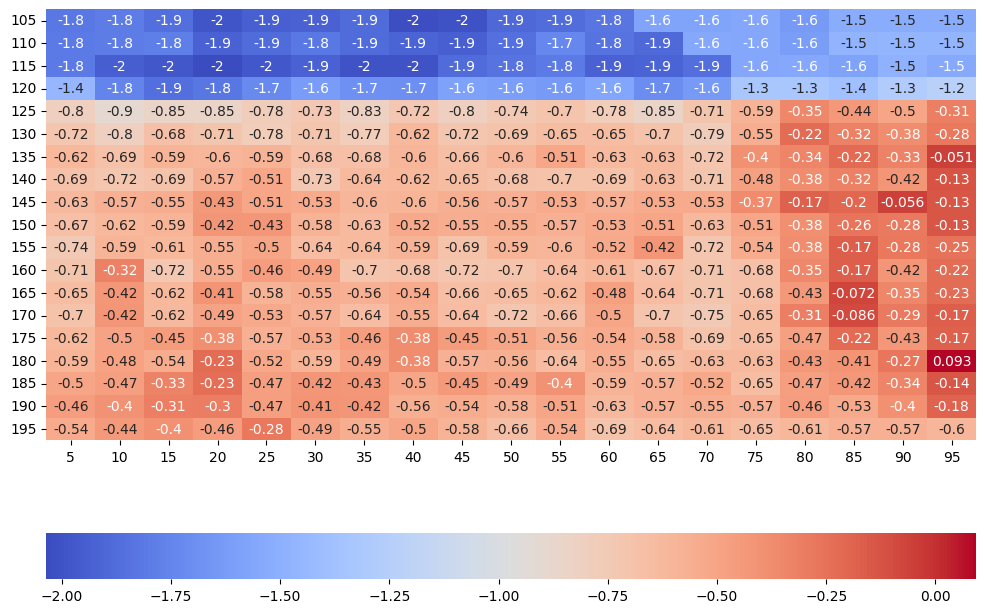

In [ ]:
PNLs = pnls[pnls.columns].astype(float)
plt.subplots(figsize = (SCREEN_X, SCREEN_Y))
sns.heatmap(PNLs, cmap='coolwarm', annot=True, cbar_kws={'orientation': 'horizontal'})

Buy-Hold    2.525483
Strategy    0.712724
Name: 2023-05-24 00:00:00, dtype: float64

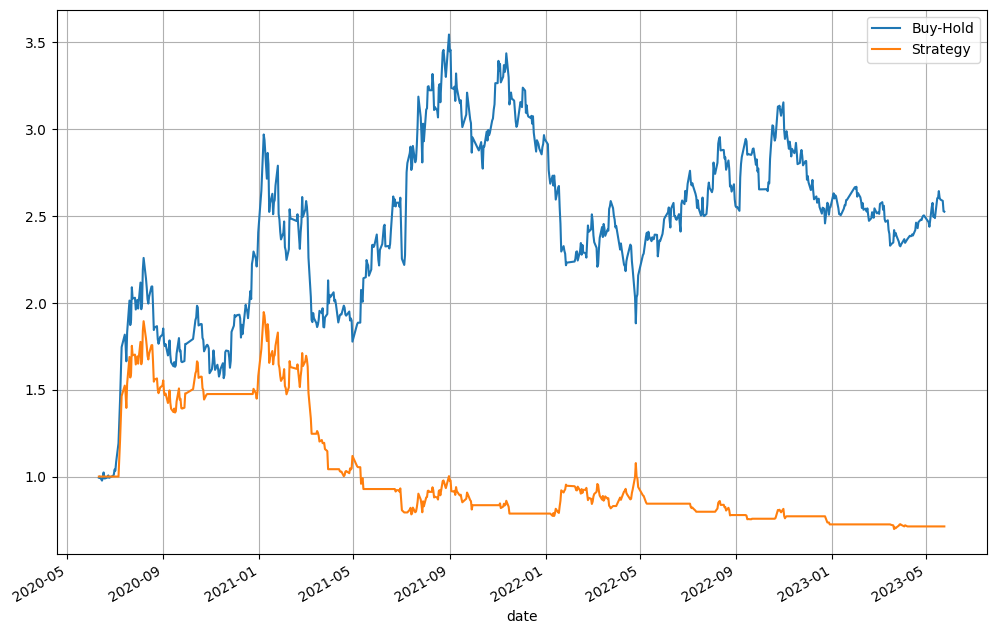

In [ ]:
lead = 5 
lag = 105

ma_df = test_ma(df, lead, lag, threshold).dropna()
ma_df[['Buy-Hold', 'Strategy']].plot(figsize = (SCREEN_X, SCREEN_Y), grid=True)
ma_df[['Buy-Hold', 'Strategy']].iloc[-1]

#5. Show the performance details of SMA strategy

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



Start date,2020-06-11
End date,2023-05-24
Total months,34
,Backtest
Annual return,-11.236%
Cumulative returns,-28.728%
Annual volatility,40.731%
Sharpe ratio,-0.09
Calmar ratio,-0.18
Stability,0.72
Max drawdown,-64.175%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,64.17,2021-01-07,2023-03-21,NaT,NaN
1,27.77,2020-08-07,2020-09-16,2021-01-07,110
2,8.44,2020-07-14,2020-07-16,2020-07-17,4
3,7.25,2020-08-03,2020-08-04,2020-08-06,4
4,7.00,2020-07-20,2020-07-21,2020-07-23,4


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



Stress Events,mean,min,max
New Normal,-0.01%,-10.01%,10.01%


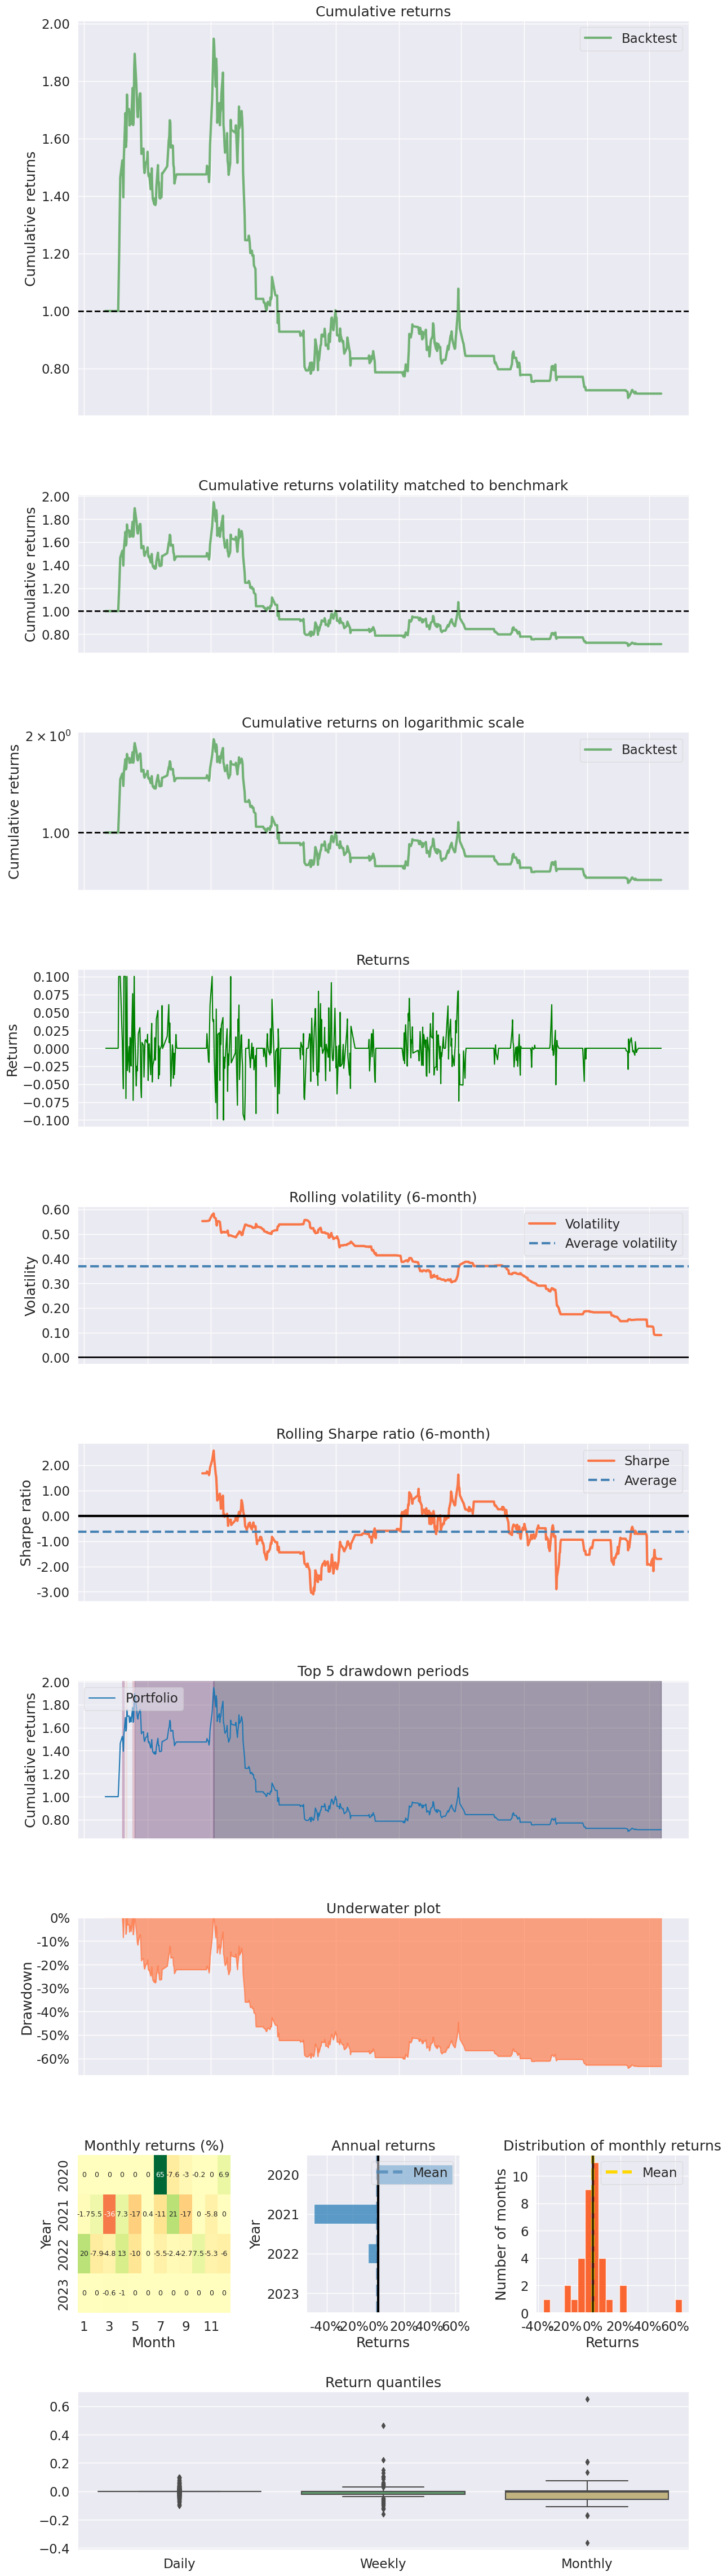

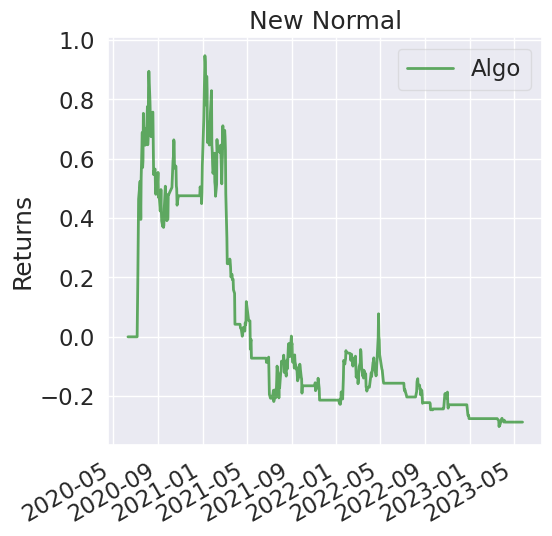

In [ ]:
pf.create_full_tear_sheet(ma_df['Strategy'].pct_change())

#6. Using machine learning to predict future trends

Epoch 1/50
19/19 [==============================] - 13s 179ms/step - loss: 0.0590
Epoch 2/50
19/19 [==============================] - 3s 176ms/step - loss: 0.0119
Epoch 3/50
19/19 [==============================] - 5s 249ms/step - loss: 0.0091
Epoch 4/50
19/19 [==============================] - 3s 178ms/step - loss: 0.0091
Epoch 5/50
19/19 [==============================] - 3s 180ms/step - loss: 0.0078
Epoch 6/50
19/19 [==============================] - 4s 223ms/step - loss: 0.0084
Epoch 7/50
19/19 [==============================] - 5s 246ms/step - loss: 0.0110
Epoch 8/50
19/19 [==============================] - 3s 177ms/step - loss: 0.0081
Epoch 9/50
19/19 [==============================] - 4s 189ms/step - loss: 0.0071
Epoch 10/50
19/19 [==============================] - 4s 231ms/step - loss: 0.0066
Epoch 11/50
19/19 [==============================] - 3s 178ms/step - loss: 0.0064
Epoch 12/50
19/19 [==============================] - 3s 180ms/step - loss: 0.0063
Epoch 13/50
19/19 [=====

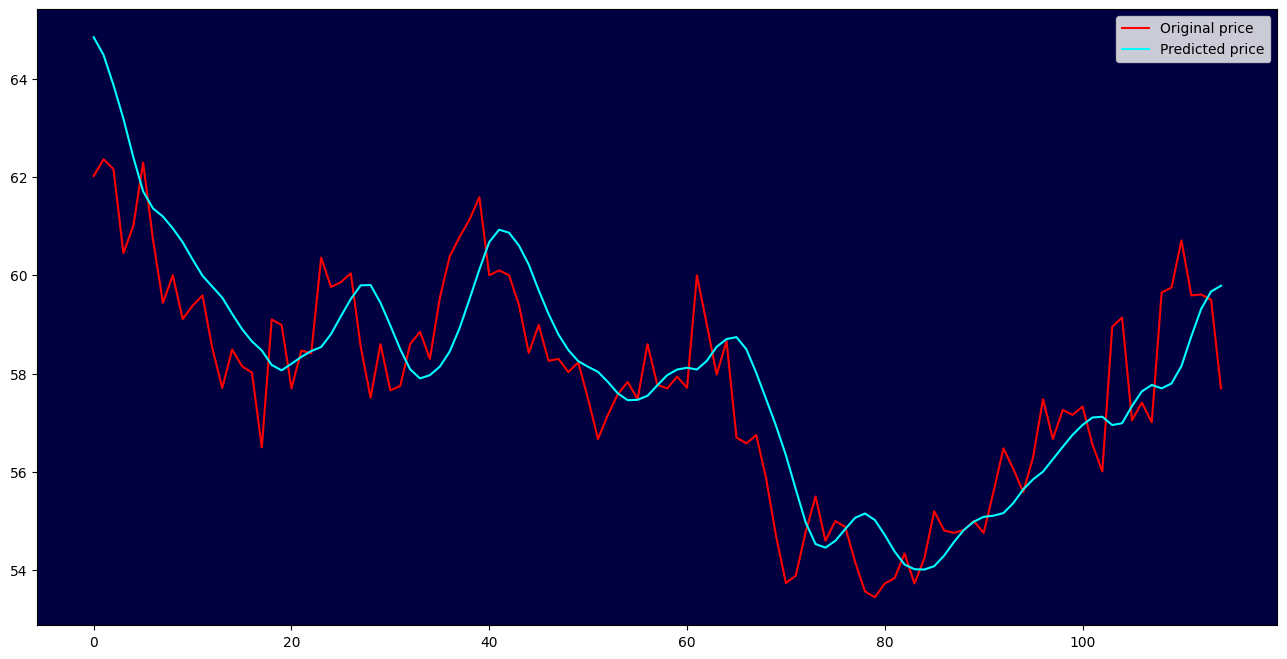

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout

from google.colab import files
df=pd.read_csv('https://raw.githubusercontent.com/Wenleiguo/zhsf/main/K-700760.csv')
df.shape
df = df['open'].values
df = df.reshape(-1, 1)
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8):])
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.transform(dataset_test)
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

x_train, y_train = create_dataset(dataset_train)
x_test, y_test = create_dataset(dataset_test)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=50, batch_size=32)
model.save('stock_prediction.h5')
model = load_model('stock_prediction.h5')
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(16,8))
ax.set_facecolor('#000041')
ax.plot(y_test_scaled, color='red', label='Original price')
plt.plot(predictions, color='cyan', label='Predicted price')
plt.legend()